# Temperature on Electricity Demand (New England)

In [24]:
%pip install xlrd==2.0.1 openpyxl scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import sklearn

%matplotlib inline



Note: you may need to restart the kernel to use updated packages.


## Table of Contents
1. #### INTRODUCTION 
    a) Context 
    b) Research Question 
    c) Motivation 
    d) Terminology 
    
2. #### DATA CLEANING
    a) Clean Main DataFrame (Comprising Hourly Demand, Load, and Temperature Data) 

3. #### GENERATION MIX 
    a) Clean Energy Generation Mix Data 

4. #### DEMAND CURVES 

5. #### OUR REGRESSION

## INTRODUCTION 

### Context and Background 
Electricty markets are highly correlated to temperature fluctuations and weather patterns. Given a particular generation mix, pool prices per KwH can fluctuate wildly if the sun is shining brightly, or evening temperatures are colder than usual.[cite research probably?] 

### Research Question

1. Has electricity demand in the ISO-NE region become more temperature sensitive over time? We look at a 6 year period from 2011 to 2017. 
2. If so, how much higher was electricity demand during the cold snap due to the heightened temperature sensitivity?

### Motivation
Our research question is motivated by findings from Shaffer et al.'s 2022 paper, which demonstrate a heightened temperature sensitivity in electricity demand in Texas. The paper estimates that this increased sensitivity resulted in an additional 8% average load during the extreme February 2021 cold snap in Texas. Our project aims to investigate whether temperature sensitivity has similarly increased in the ISO-NE region and to examine the effect this had during the cold snap in 2018.

### Terminology 
ISO-NE (probably describe in context instead). Add more as we go


## Data Cleaning

### Electricity Demand + Price + Temperature (Hourly)

https://www.iso-ne.com/isoexpress/

In [25]:
states = ['ISONE CA', 'ME', 'NH', 'VT', 'CT', 'RI', 'SEMASS' ,'WCMASS', 'NEMASSBOST']

state_dfs = [pd.DataFrame(columns=['Date', 'Hour', 'DA Demand', 'RT Demand',
                                   'DA Price', 'RT Price', 'Temperature', 'Region']) for _ in states]

state_names = ['isone_ca', 'me', 'nh', 'vt', 'ct', 'ri', 'sema', 'wcma', 'nema']

state_names_full = ['ISO-NE Control Area', 'Maine', 'New Hampshire', 'Vermont',
                    'Connecticut', 'Rhode Island', 'SouthEastern Massachusetts',
                    'Western & Central Massachusetts', 'NorthEastern Massachusetts & Boston']

#### DO NOT TOUCH (Cleaning for final project)

In [26]:
"""
THIS IS THE CLEANING CODE FOR THE RAW DATA, DO NOT TOUCH IT
"""

# for year in range(2011, 2018):
#     path = f"data/demand/{year}_smd_hourly.xls"
#     if year >= 2016:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'RT_LMP', 'Dry_Bulb']]
#             state_df = state_df.rename(columns = {'RT_Demand' : 'RT Demand', 'Dry_Bulb' : 'Temperature',
#                                                     'DA_Demand' : 'DA Demand', 'DA_LMP' : 'DA Price',
#                                                     'RT_LMP' : 'RT Price', 'Hr_End' : 'Hour'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd/mm/yy')
#             state_df['Region'] = state_names_full[i]
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
#     else:
#         for i, state in enumerate(states):
#             state_df = pd.read_excel(path, sheet_name = state)
#             state_df = state_df[['Date', 'Hour', 'DA_DEMD', 'DEMAND', 'DA_LMP', 'RT_LMP', 'DryBulb']]
#             state_df = state_df.rename(columns = {'DEMAND' : 'RT Demand', 'DryBulb' : 'Temperature',
#                                                     'DA_DEMD' : 'DA Demand', 'DA_LMP' : 'DA Price',
#                                                     'RT_LMP' : 'RT Price'})
#             state_df['Date'] = pd.to_datetime(state_df['Date'], format = 'dd/mm/yy')
#             state_df['Region'] = state_names_full[i]
            
#             state_dfs[i] = pd.concat([state_dfs[i], state_df], ignore_index = True)
            
# for i in range(len(state_dfs)):
#     #Set index as datetime
#     state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
#     state_dfs[i] = state_dfs[i].set_index('Datetime')
    
#     #Add Year column
#     state_dfs[i]['Year'] = pd.to_datetime(state_dfs[i]['Date']).dt.year
#     columns = ['Year', 'Region'] + [col for col in state_dfs[i].columns if col not in ['Year', 'Region']]
#     state_dfs[i] = state_dfs[i][columns]
    
#     #Remove all rows with 0 demand
#     state_dfs[i] = state_dfs[i][state_dfs[i]['RT Demand'] != 0]

'\nTHIS IS THE CLEANING CODE FOR THE RAW DATA, DO NOT TOUCH IT\n'

In [27]:
for i in range(len(state_names)):
    path = f"data/Others/demand/{state_names[i]}.csv"
    state_dfs[i] = pd.read_csv(path)
    state_dfs[i]["Date"] = pd.to_datetime(state_dfs[i]["Date"])

In [28]:
state_dfs[1].head()
state_dfs[1][0:40]


,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature
0,2011,Maine,2011-01-01,1,952.2,1048.0,37.80,40.68,31
1,2011,Maine,2011-01-01,2,905.2,1000.0,36.27,33.92,31
2,2011,Maine,2011-01-01,3,860.6,964.0,35.41,34.27,32
3,2011,Maine,2011-01-01,4,843.9,954.0,35.40,32.96,35
4,2011,Maine,2011-01-01,5,863.9,960.0,35.59,32.51,34
5,2011,Maine,2011-01-01,6,906.1,983.0,35.78,33.40,33
6,2011,Maine,2011-01-01,7,1021.8,1028.0,37.82,33.24,34
7,2011,Maine,2011-01-01,8,1112.3,1085.0,39.04,29.46,34
8,2011,Maine,2011-01-01,9,1128.6,1158.0,82.48,31.63,34
9,2011,Maine,2011-01-01,10,1275.2,1232.0,39.38,31.66,38


### Natural Gas Prices (Daily)

https://www.eia.gov/dnav/ng/ng_pri_sum_a_EPG0_PG1_DMcf_m.htm

We control for natural gas prices because we expect them

In [29]:
ng = pd.read_excel('data/NG_PRI_SUM_A_EPG0_PG1_DMCF_M.xls', sheet_name = 'Data 1',
                   skiprows = 2)

ng = ng[['Date', 'Natural Gas Citygate Price in Connecticut (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Maine (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in Massachusetts (Dollars per Thousand Cubic Feet)', 
         'Natural Gas Citygate Price in New Hampshire (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Rhode Island (Dollars per Thousand Cubic Feet)',
         'Natural Gas Citygate Price in Vermont (Dollars per Thousand Cubic Feet)']]

ng.columns = ['Date', 'Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']

ng = ng[(ng['Date'] >= '2011-01-01') & (ng['Date'] <= '2017-12-31')]

ng['year_month'] = ng['Date'].dt.to_period('M')

ng.head()

,Date,Connecticut,Maine,Massachusetts,New Hampshire,Rhode Island,Vermont,year_month
456,2011-01-15,5.74,7.59,6.70,8.06,7.82,7.60,2011-01
457,2011-02-15,5.93,7.24,6.90,7.22,7.62,7.72,2011-02
458,2011-03-15,5.66,8.65,6.57,8.30,7.03,8.04,2011-03
459,2011-04-15,5.87,7.53,7.25,7.72,7.09,8.69,2011-04
460,2011-05-15,6.67,9.97,7.84,7.95,9.80,8.87,2011-05


In [30]:
for i in range(len(state_dfs)):
    state_dfs[i]['year_month'] = state_dfs[i]['Date'].dt.to_period('M')
    #All New England - no NG price data
    if i == 0:
        state_dfs[i].drop(columns = ['year_month'], inplace = True)
        continue
    #Maine
    elif i == 1:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Maine']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Maine': 'Natural Gas Price'})
    #New Hampsphire
    elif i == 2:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'New Hampshire']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'New Hampshire': 'Natural Gas Price'})
    #Vermont
    elif i == 3:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Vermont']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Vermont': 'Natural Gas Price'})
    #Connecticut
    elif i == 4:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Connecticut']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Connecticut': 'Natural Gas Price'})
    #Rhode Island
    elif i == 5:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Rhode Island']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Rhode Island': 'Natural Gas Price'})
    #Massachusetts
    else:
        state_dfs[i] = pd.merge(state_dfs[i], ng[['year_month', 'Massachusetts']], on = 'year_month', how = 'left')
        state_dfs[i] = state_dfs[i].rename(columns={'Massachusetts': 'Natural Gas Price'})
    state_dfs[i].drop(columns = ['year_month'], inplace = True)

In [31]:
state_dfs[1].head()

,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature,Natural Gas Price
0,2011,Maine,2011-01-01,1,952.2,1048.0,37.80,40.68,31,7.59
1,2011,Maine,2011-01-01,2,905.2,1000.0,36.27,33.92,31,7.59
2,2011,Maine,2011-01-01,3,860.6,964.0,35.41,34.27,32,7.59
3,2011,Maine,2011-01-01,4,843.9,954.0,35.40,32.96,35,7.59
4,2011,Maine,2011-01-01,5,863.9,960.0,35.59,32.51,34,7.59


### Generation Mix (Daily)

https://www.iso-ne.com/isoexpress/web/reports/operations/-/tree/daily-gen-fuel-type

We will now introduce data on the daily generation mix for two main reasons: 

(i) , and; (ii)


Steps taken within *Energy Generation Mix (Daily)* Section:
1. Loading and Cleaning the Energy Generation Mix Data from 2011 to 2017
2. Defining Percentages of Total Fuel Demand Per Fuel Type
3. Visualizing the Fuel Demand Per Fuel Type:
    a. Over Time
    b. For Abnormalities


#### 1. Loading and Cleaning the Energy Generation Mix Data from 2011 to 2017

In [32]:
dataframes_genmix = []
pct_data = []

for year_genmix in range(2011, 2018):
    # Define the path to your file for the current year
    data_path_genmix = f"data/gen_mix/{year_genmix}_daygenbyfuel.xlsx"
    sheet = "POST-EMOF Fuel Types" if year_genmix <= 2013 else "POST-EMOF Gen_w_Blending"

    # Read the data from the specific sheet for each year
    genmix_df = pd.read_excel(data_path_genmix, sheet_name=sheet)
    
    genmix_df = genmix_df.dropna(subset=['DATE'])
    genmix_df['DATE'] = pd.to_datetime(genmix_df['DATE'], format='%m/%d/%Y', errors='coerce')

    dataframes_genmix.append(genmix_df)
    
    #Percentage Dataframe
    genmix_pct = genmix_df.copy()
    
    for col in genmix_pct.columns:
        if col != 'DATE':
            genmix_pct[col] = genmix_pct[col] / genmix_pct['TOTAL'] * 100
    
    pct_data.append(genmix_pct)
    

#Fuel Data
final_genmix_df = pd.concat(dataframes_genmix, ignore_index=True)
final_genmix_df.columns = [col.title() for col in final_genmix_df.columns]
final_genmix_df = final_genmix_df.drop(columns = ['Total'])

#Percentage Data
genmix_pct = pd.concat(pct_data, ignore_index=True)
genmix_pct = genmix_pct.drop(columns = ['TOTAL', 'OTHER', 'STEAM'])
genmix_pct.columns = [col.title() for col in genmix_pct.columns]
genmix_pct.columns = [col + " Pct" if col != 'Date' else col for col in genmix_pct.columns]

#### DataFrame for all Fuel Types (for Visualizations)

In [33]:
final_genmix_df.head()

,Date,Coal,Gas,Hydro,Nuclear,Oil,Landfill Gas,Methane,Refuse,Solar,Steam,Wind,Wood,Other
0,2011-01-01,20552.396,108641.394,20919.195,112147.889,-29.800,1320.874,137.195,9488.731,8.670,555.0,1122.004,7765.738,NaN
1,2011-01-02,20163.527,117377.411,25181.303,112143.165,865.881,1361.649,136.302,9711.649,6.816,554.0,1433.706,7768.051,NaN
2,2011-01-03,27166.663,160266.142,29681.796,112054.041,-55.636,1305.818,141.241,9641.529,15.152,535.0,4644.886,8129.366,NaN
3,2011-01-04,38256.357,154016.112,27829.059,112125.295,-56.624,1281.397,133.375,8517.200,7.716,589.0,3340.066,8404.685,NaN
4,2011-01-05,39574.746,155309.212,29021.944,112105.759,978.276,1230.426,136.396,8044.773,11.592,589.0,4021.743,8509.108,NaN


#### 2. Defining Percentages of Total Fuel Demand Per Fuel Type

In [34]:
genmix_pct.head()

,Date,Coal Pct,Gas Pct,Hydro Pct,Nuclear Pct,Oil Pct,Landfill Gas Pct,Methane Pct,Refuse Pct,Solar Pct,Wind Pct,Wood Pct
0,2011-01-01,7.271078,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
1,2011-01-02,6.795176,39.556577,8.486183,37.792619,0.291805,0.458880,0.045934,3.272858,0.002297,0.483164,2.617859
2,2011-01-03,7.682999,45.324840,8.394304,31.689984,-0.015734,0.369298,0.039944,2.726719,0.004285,1.313619,2.299065
3,2011-01-04,10.791102,43.443852,7.849838,31.627566,-0.015972,0.361448,0.037622,2.402476,0.002176,0.942144,2.370738
4,2011-01-05,11.005052,43.188803,8.070500,31.174671,0.272042,0.342160,0.037929,2.237112,0.003224,1.118377,2.366236


In [35]:
for i in range(len(state_dfs)):
    state_dfs[i] = pd.merge(state_dfs[i], genmix_pct, how = 'left', on = 'Date')
    state_dfs[i]['Datetime'] = pd.to_datetime(state_dfs[i]['Date']) + pd.to_timedelta(state_dfs[i]['Hour'], unit='h')
    state_dfs[i] = state_dfs[i].set_index('Datetime')

In [36]:
#Final Data
state_dfs[1].head()

,Year,Region,Date,Hour,DA Demand,RT Demand,DA Price,RT Price,Temperature,Natural Gas Price,...,Gas Pct,Hydro Pct,Nuclear Pct,Oil Pct,Landfill Gas Pct,Methane Pct,Refuse Pct,Solar Pct,Wind Pct,Wood Pct
Datetime,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,2011,Maine,2011-01-01,1,952.2,1048.0,37.80,40.68,31,7.59,...,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
2011-01-01 02:00:00,2011,Maine,2011-01-01,2,905.2,1000.0,36.27,33.92,31,7.59,...,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
2011-01-01 03:00:00,2011,Maine,2011-01-01,3,860.6,964.0,35.41,34.27,32,7.59,...,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
2011-01-01 04:00:00,2011,Maine,2011-01-01,4,843.9,954.0,35.40,32.96,35,7.59,...,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382
2011-01-01 05:00:00,2011,Maine,2011-01-01,5,863.9,960.0,35.59,32.51,34,7.59,...,38.435423,7.400845,39.675959,-0.010543,0.467302,0.048537,3.356947,0.003067,0.396945,2.747382


After cleaning the


## Data Analysis

**state_dfs** is a list containing 9 dataframes, index the list to access each region

This is the order of the regions: state_names = ['isone_ca', 'me', 'nh', 'vt', 'ct', 'ri', 'sema', 'wcma', 'nema']

**ng** is a dataframe containing natural gas prices (columns: regions, rows: date)

**final_genmix_df** is a dataframe containing fuel type distribution in generation mix (columns: fuel type, rows: date)

### Electricity Demand, Price and Temperature

Text(0.5, 1.0, 'Electricity Demand on Temperature (Entire ISO-NE)')

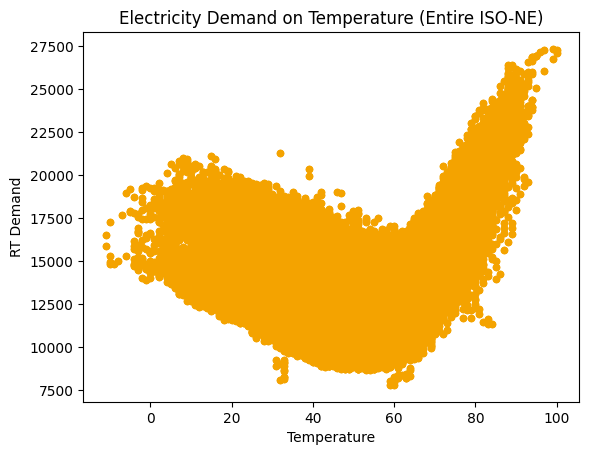

In [37]:
state_dfs[0].plot.scatter('Temperature', 'RT Demand', color = '#F4A300')
plt.title('Electricity Demand on Temperature (Entire ISO-NE)')

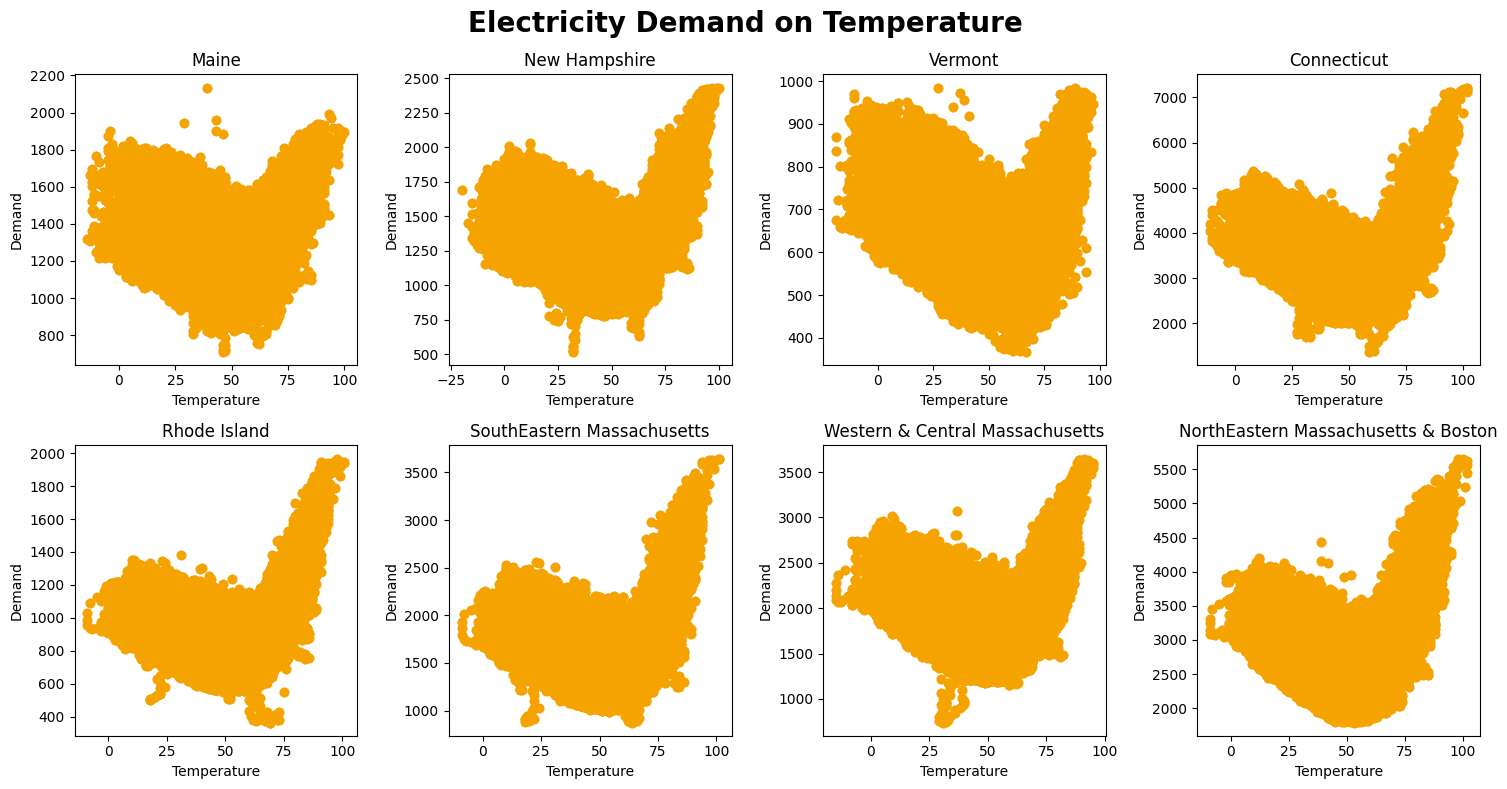

In [38]:
# Assuming `state_dfs` is a list of 8 DataFrames and `state_names` is a list of 8 titles
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):
    axes[i].scatter(df['Temperature'], df['RT Demand'], color = '#F4A300')
    axes[i].set_title(name)
    axes[i].set_ylabel('Demand')
    axes[i].set_xlabel('Temperature')

fig.suptitle('Electricity Demand on Temperature', fontsize=20, fontweight='bold')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

We should probably try to fit a line going through here so we can best visualize the plots -- but again this is the preliminary data etc

In [39]:
for i in range(len(state_dfs)):
    state_dfs[i]['Demand Diff'] = state_dfs[i]['RT Demand'] - state_dfs[i]['DA Demand']
    state_dfs[i]['Price Diff'] = state_dfs[i]['RT Price'] - state_dfs[i]['DA Price']

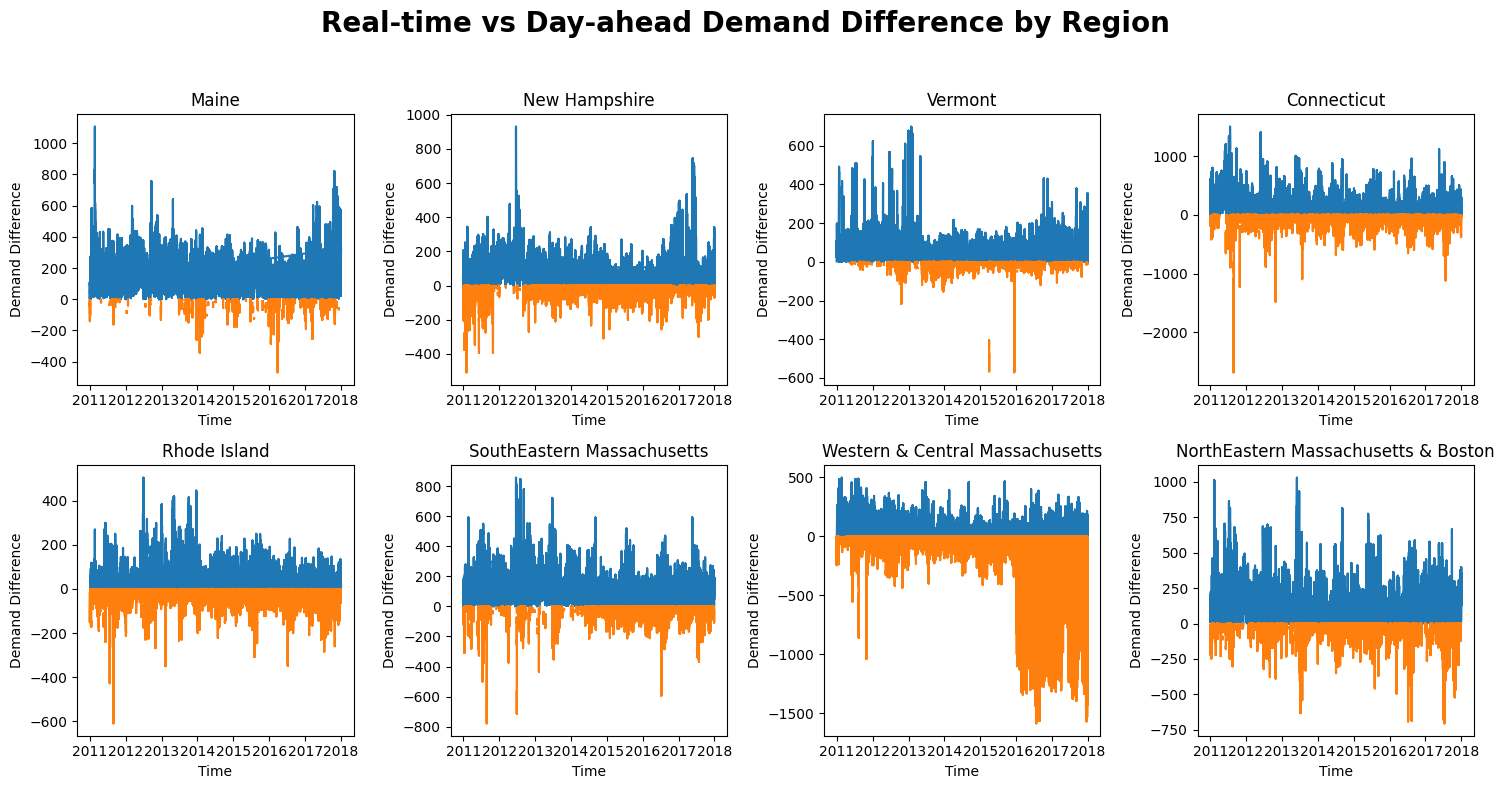

In [47]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):  # Assuming state_names matches state_dfs
    ax = axes[i]
    
    # Plot positive and negative values separately
    positive = df['Demand Diff'].where(df['Demand Diff'] >= 0)
    negative = df['Demand Diff'].where(df['Demand Diff'] < 0)
    
    ax.plot(df.index, positive, color='#1f77b4', label='Positive')
    ax.plot(df.index, negative, color='#ff7f0e', label='Negative')
    
    # Add titles and labels
    ax.set_title(name)
    ax.set_ylabel('Demand Difference')
    ax.set_xlabel('Time')
    
fig.suptitle('Real-time vs Day-ahead Demand Difference by Region', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

plt.show()

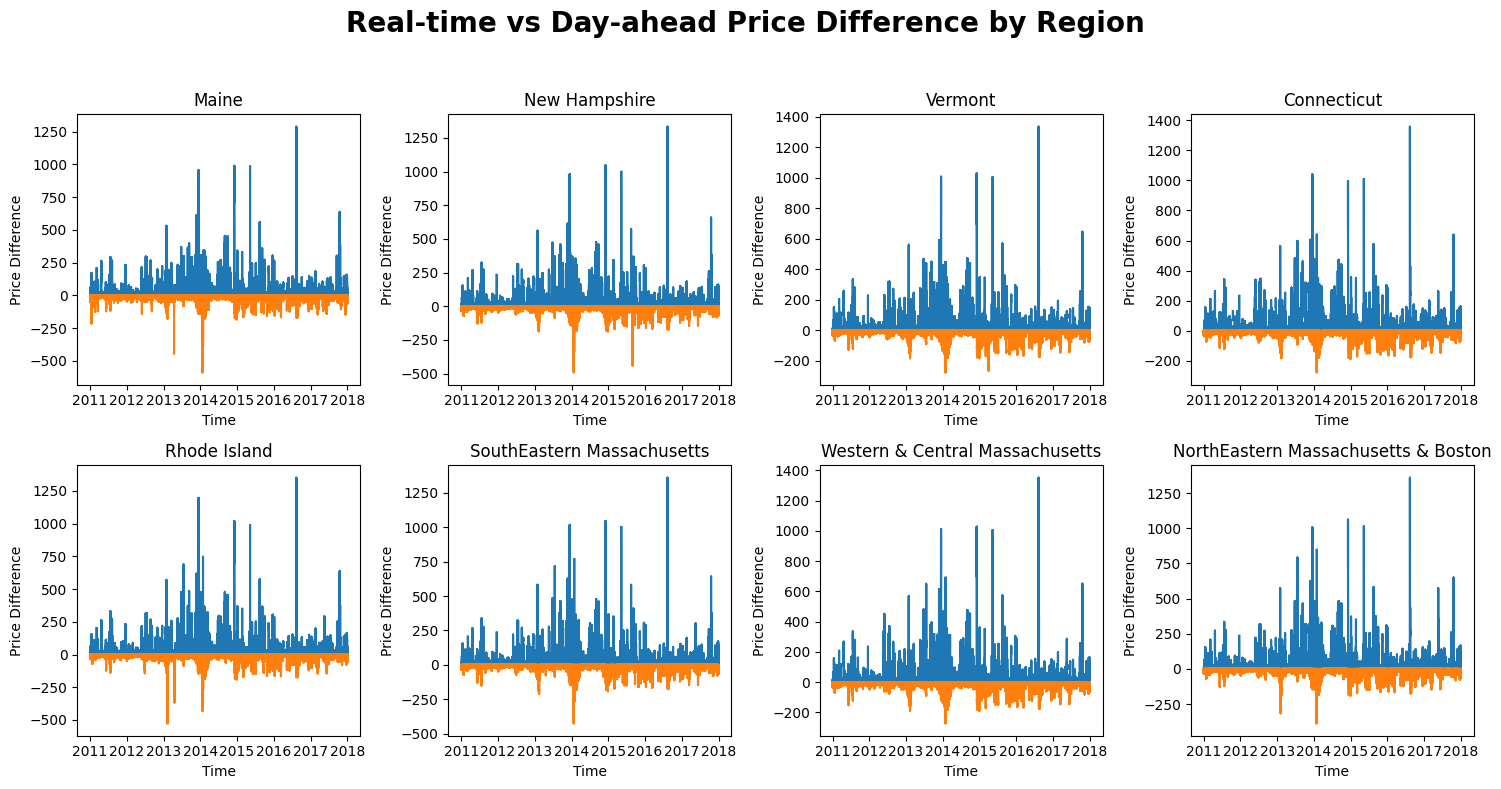

In [46]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))  # Creates a 2x4 grid of subplots

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each DataFrame and corresponding title
for i, (df, name) in enumerate(zip(state_dfs[1:], state_names_full[1:])):  # Assuming state_names matches state_dfs
    ax = axes[i]
    
    # Plot positive and negative values separately
    positive = df['Price Diff'].where(df['Price Diff'] >= 0)
    negative = df['Price Diff'].where(df['Price Diff'] < 0)
    
    ax.plot(df.index, positive, color='#1f77b4', label='Positive')
    ax.plot(df.index, negative, color='#ff7f0e', label='Negative')
    
    # Add titles and labels
    ax.set_title(name)
    ax.set_ylabel('Price Difference')
    ax.set_xlabel('Time')

fig.suptitle('Real-time vs Day-ahead Price Difference by Region', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect to leave space for the suptitle

plt.show()

### Generation Mix

In [42]:
final_genmix_df_melted = final_genmix_df.melt(id_vars=['Date'], var_name='Fuel Type', value_name='Demand')
final_genmix_df_melted['Date'] = pd.to_datetime(final_genmix_df_melted['Date'])

final_genmix_df_melted.head()

# This won't run for me, am I missing something? 

,Date,Fuel Type,Demand
0,2011-01-01,Coal,20552.396
1,2011-01-02,Coal,20163.527
2,2011-01-03,Coal,27166.663
3,2011-01-04,Coal,38256.357
4,2011-01-05,Coal,39574.746


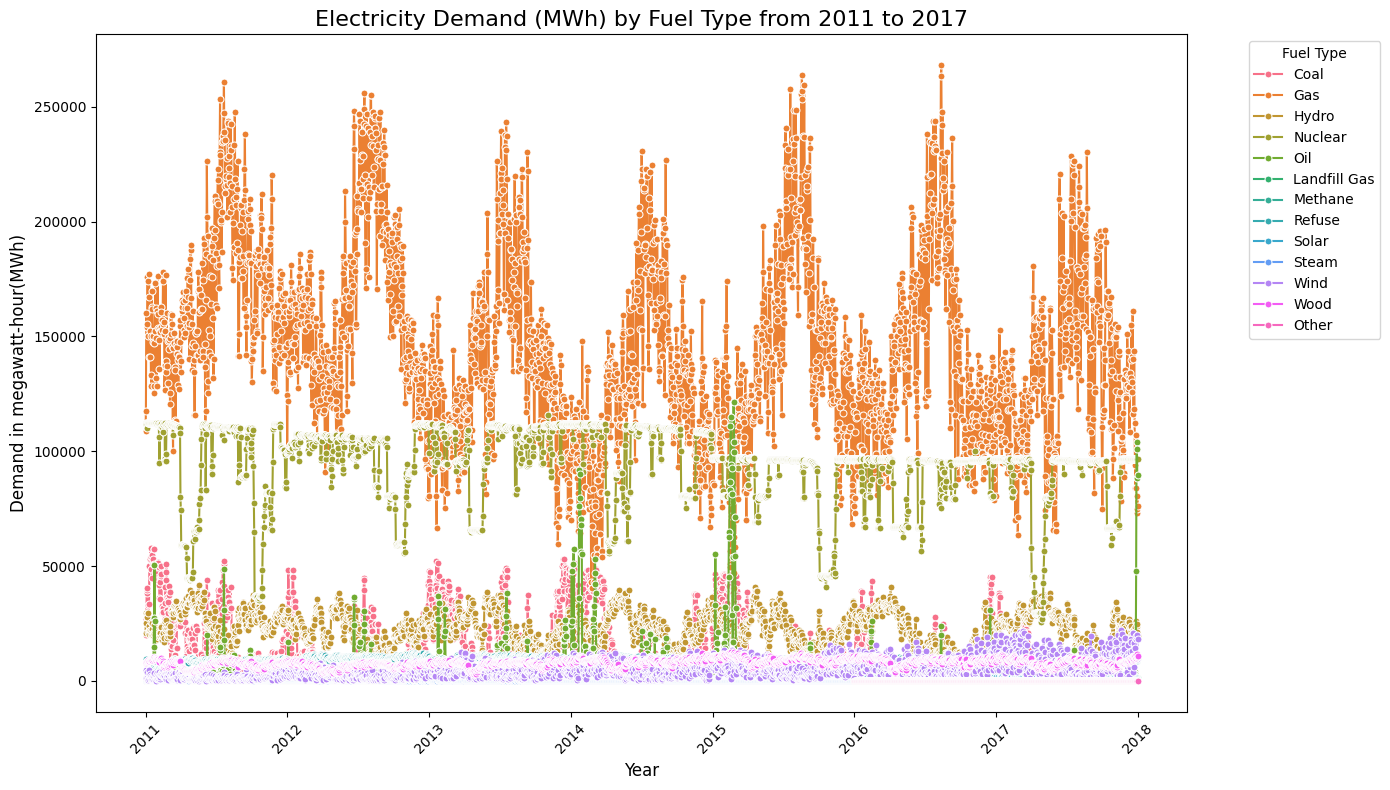

In [43]:
custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(14, 8))
sns.lineplot(data=final_genmix_df_melted, x='Date', y='Demand', hue='Fuel Type', marker='o', markersize=5)
plt.title('Electricity Demand (MWh) by Fuel Type from 2011 to 2017', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Demand in megawatt-hour(MWh)', fontsize=12)
plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

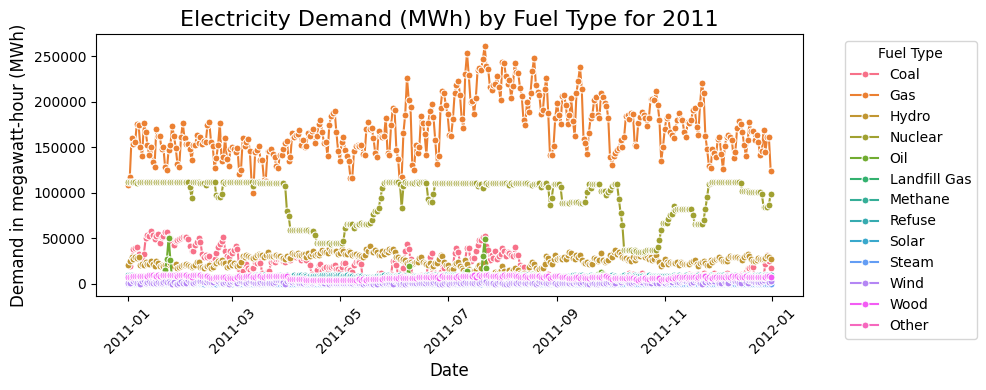

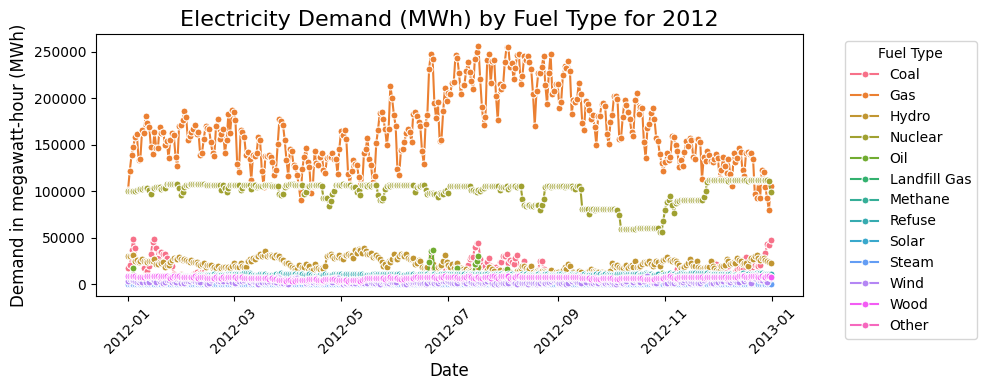

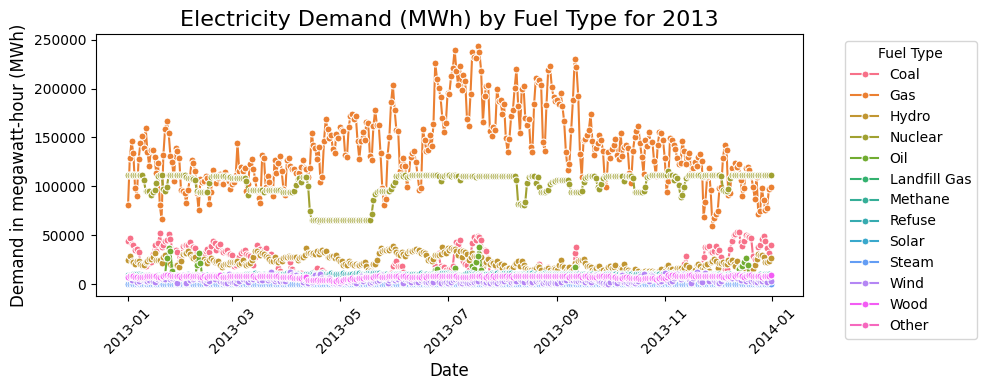

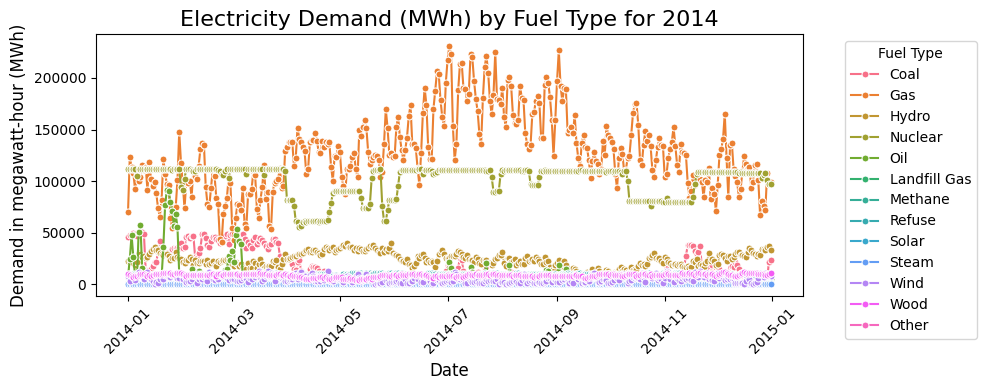

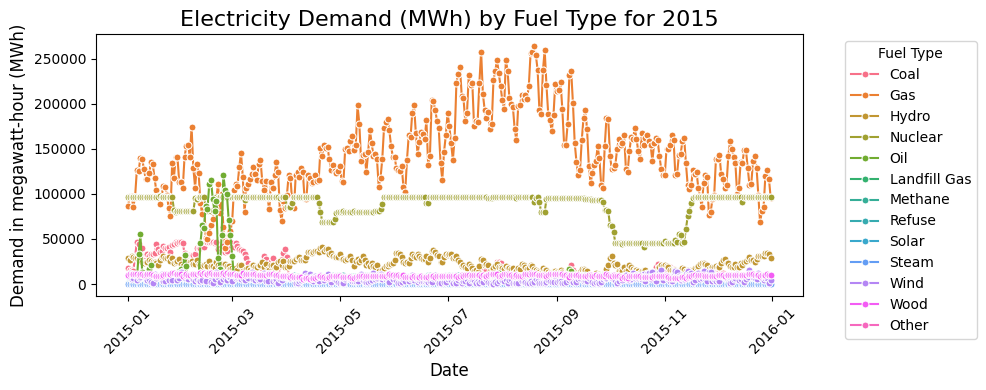

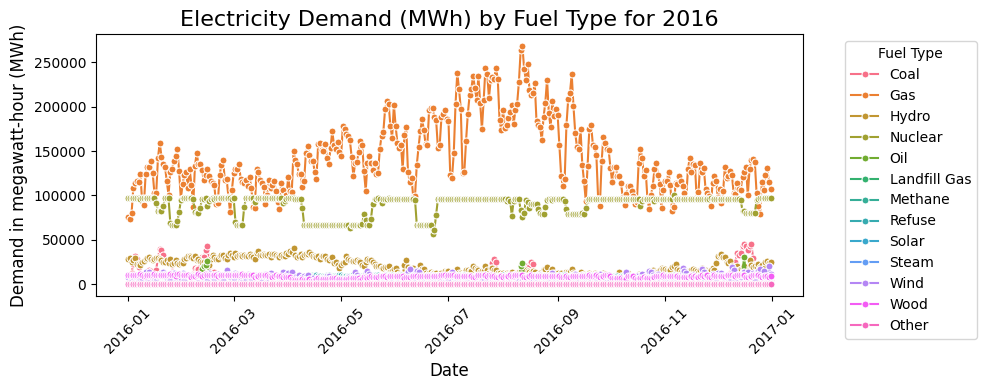

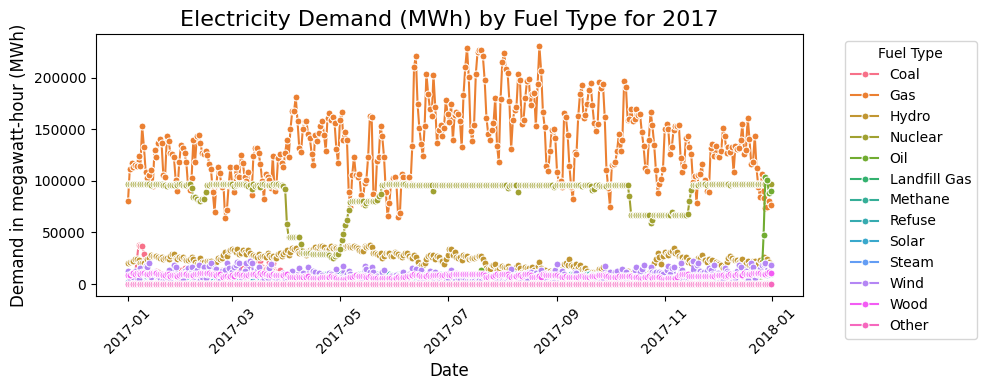

In [44]:
for year in range(2011, 2018):
    plt.figure(figsize=(10, 4))

    year_data_genmix = final_genmix_df_melted[final_genmix_df_melted["Date"].dt.year == year]

    sns.lineplot(data=year_data_genmix, x='Date', y='Demand', hue='Fuel Type', marker='o', markersize=5)
    
    plt.title(f'Electricity Demand (MWh) by Fuel Type for {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Demand in megawatt-hour (MWh)', fontsize=12)
    plt.legend(title='Fuel Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    

    plt.tight_layout()
    plt.show()

## Our Regression

In this section, we will be estimating the **temperature response function**. This function will help explain the relationship between temperature and electricity demand , measured in megawatt-hours (MWh). We will run a two types of regressions: one where temperature is binned and another where we include a non-linear term for temperature.

#### a) Regression 1 - Binned Temperature 

Our **motivation** for using a regression with binned temperature is ...




We will employ the following regression:

$$
\log \text{Load}_{t,z} = \sum_{b} \beta_{b,z} \text{Temp}_{bt,z} + \theta_{z} X_{t,z} + \epsilon_{t,z}
$$

Where:
* The **Dependent Variable** is $\log \text{Load}_{t,z}$. This is the logarithmic function of hourly electricity load $y$ in zone $z$ at time $t$.  
Log-transformation will allow us to interpretat the $\log \text{Load}_{t,z}$ change as a percentage changes.

* The **Temperature Variables** is $T_{b,t,z}$. We have binned the temperature variable so it represents a series of temperature dummies that indicate whether the temperature in hour $t$  for zone $z$ falls into a specific 3°C temperature interval. We are using temperature binned at 3°C intervals to capture non-linear relationships between temperature and demand. As per Shaffer et al's paper, we have omitted 18.5°C - we interpret this to be out *neutral point*, where heating and cooling demand are at their lowest. The **Coefficients** $\beta_{b,z}$ measure the effect of each temperature range (bin, $b$) on electricity demand in zone $z$, *relative* to the demand at 18.5°C.

* The **Fixed Effects Variable** $X_{t,z}$ includes date and time controls to account for patterns in electricity demand that are *unrelated to temperature* (e.g., time of day, day of week, etc.).
Specifically in this regression we use...

* The **Residual Variable** $\epsilon_{t,z}$ captures unexplained variation in electricity demand after accounting for temperature and fixed effects.

##### a) i) Fixed Effects


#### a) Regression 2 - Quadratic Model

Instead of binning temperature into intervals, we will use a quadratic regression model to capture both linear and non-linear temperature effects. Our **motivation** for this uses previous literature ("") which states that ...



We will employ the following regression to do so:

$$
\log \text{Load}_{t,z} = \beta_0 + \beta_1 \text{Temp}_{t,z} + \beta_2 \text{Temp}_{t,z}^2 + \theta_z X_{t,z} + \epsilon_{t,z}
$$

Where:

* The **Dependent Variable** is $\log \text{Load}_{t,z}$. How does the interetation change??

* The **Temperature Variables** are $T_{t,z}$ and $T_{t,z}^2$. In this model, we use the temperature in zone $z$ at time $t$ both as a linear term ($T_{t,z}$) and as a squared term ($T_{t,z}^2$). This quadratic specification allows us to model the non-linear effects of temperature on electricity demand. For example, demand might increase with temperature, but at a decreasing or increasing rate depending on whether the quadratic term is positive or negative - we expect that demand will increase at an increasing rate.

* The **Fixed Effects Variable** $X_{t,z}$ includes date and time controls to account for patterns in electricity demand that are *unrelated to temperature* (e.g., time of day, day of week, etc.).
Specifically in this regression we use...

* The **Residual Variable** $\epsilon_{t,z}$ captures unexplained variation in electricity demand after accounting for temperature and fixed effects.

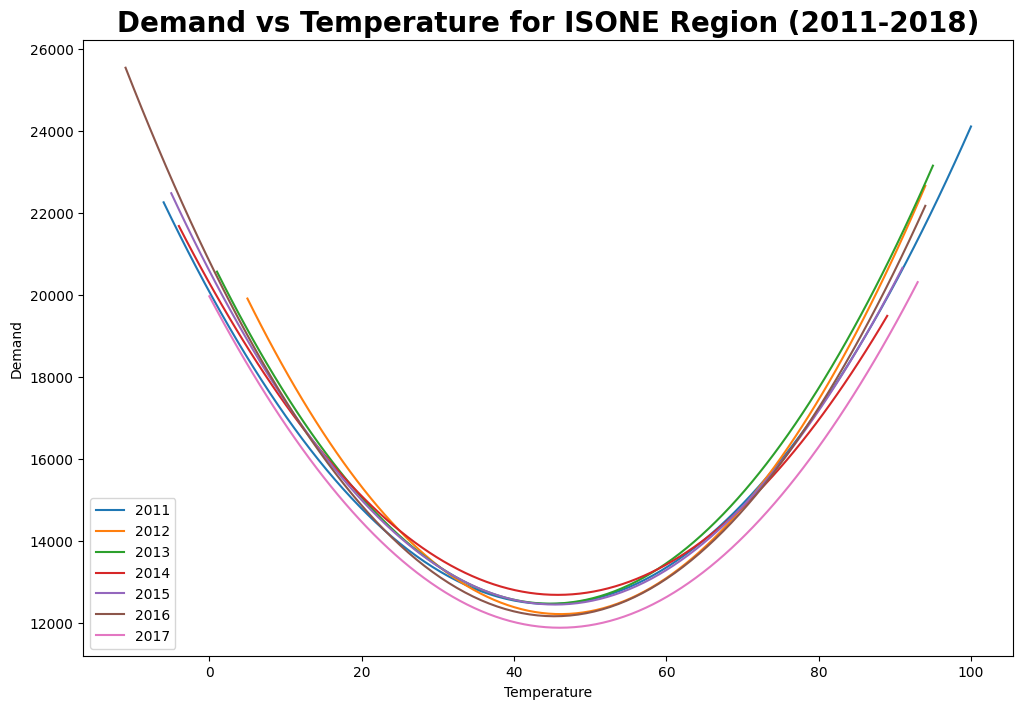

In [45]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

isone_df = state_dfs[0]  # Assuming ISONE is the first in the list

# Prepare the plot
plt.figure(figsize=(12, 8))

# Loop through each year
for year in isone_df['Year'].unique():
    year_df = isone_df[isone_df['Year'] == year]
    X = year_df['Temperature'].values.reshape(-1, 1)
    y = year_df['DA Demand'].values

    # Fit quadratic regression
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly, y)

    # Predict values
    X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_poly_pred = poly_reg.predict(poly.fit_transform(X_range))

    # Plotting
    plt.plot(X_range, y_poly_pred, label=f'{year}')

plt.title('Demand vs Temperature for ISONE Region (2011-2018)', fontsize=20, fontweight='bold')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [47]:
# Inspect the polynomial features
print("Polynomial Features:")
print(poly.get_feature_names_out(['Temperature']))

# Check the coefficients
print("Coefficients:")
print(poly_reg.coef_)
print("Intercept:")
print(poly_reg.intercept_)


Polynomial Features:
['1' 'Temperature' 'Temperature^2']
Coefficients:
[   0.         -351.6536166     3.82123637]
Intercept:
19972.86765603829
